**1. Прочитайте базу "COVID_19_data"** и сделайте модель для сглаженой формы(экспоненциально) по приросту(первые разности) ил по прямому ряду для выздоровлений(или заболеваний) с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .
**на уроке дано задание - сделать побольше признаков и построить по ним модель**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

func

In [3]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [4]:
def smoothing(series, h):
    res = series[:h]
    res = res.append(series.rolling(window=h).mean()[h:])
    return res

In [5]:
def f_differ(series):
    fod = [0]
    fod[1:] = series[1:].values - series[:-1].values 
    return fod

In [6]:
covid = pd.read_csv('D:/AI/Machine learning/novel-corona-virus-2019-dataset/covid_19_data.csv')


In [7]:
covid.tail(3)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
15766,15767,04/16/2020,Yukon,Canada,2020-04-16 23:38:19,8.0,0.0,0.0
15767,15768,04/16/2020,Yunnan,Mainland China,2020-04-16 23:38:19,184.0,2.0,176.0
15768,15769,04/16/2020,Zhejiang,Mainland China,2020-04-16 23:38:19,1268.0,1.0,1244.0


Making a dataframe copy and working with it only
Выносим дату отдельным столбцом

In [8]:
covid_19 = covid.copy()
covid_19['Date']= pd.to_datetime(covid['ObservationDate']).dt.date

In [9]:
#checking date repeats; finding number of dates
if len(covid_19['Date'].value_counts())==covid_19['Date'].nunique():
    print(covid_19['Date'].nunique())

86


In [10]:
covid_by_date = covid_19.groupby(['Date'])['Confirmed','Deaths','Recovered'].sum()

In [11]:
covid_by_date.index = pd.to_datetime(covid_by_date.index)

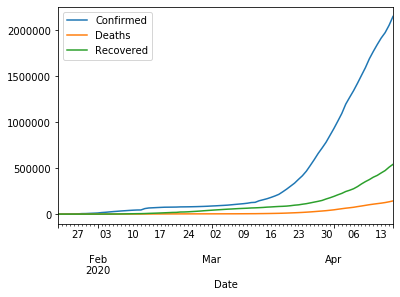

In [12]:
covid_by_date.plot()

In [13]:
covid_by_date.head(3)

,Confirmed,Deaths,Recovered
Date,,,
2020-01-22,555.0,17.0,28.0
2020-01-23,653.0,18.0,30.0
2020-01-24,941.0,26.0,36.0


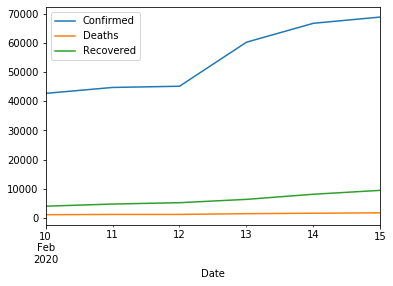

In [14]:
covid_by_date['2020-02-10': '2020-02-15'].plot()

recovered - smooth line  
**trying logarithm 'Recovered'**

In [15]:
covid_log = pd.Series(np.log(covid_by_date['Recovered']))

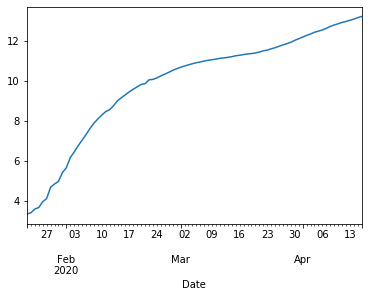

In [16]:
covid_log.plot()

In [17]:
#adding a column
covid_by_date['Logarithm'] = pd.Series(np.log(covid_by_date['Recovered']))

In [18]:
covid_by_date.loc[covid_by_date.index > pd.to_datetime('2020-02-13'), 'Logarithm']

Date
2020-02-14     8.994421
2020-02-15     9.147933
2020-02-16     9.293302
2020-02-17     9.440102
2020-02-18     9.571645
                ...    
2020-04-12    12.952102
2020-04-13    13.014009
2020-04-14    13.069513
2020-04-15    13.144162
2020-04-16    13.203219
Name: Logarithm, Length: 63, dtype: float64

добавляем простое сглаживание с разными окнами, хотя при таком прогрессивном постоянном росте вряд ли это даст что-то

In [19]:
covid_by_date['smoothing_win2'] = smoothing(covid_by_date['Recovered'], 2)
covid_by_date['smoothing_win5'] = smoothing(covid_by_date['Recovered'], 5)
covid_by_date['smoothing_win9'] = smoothing(covid_by_date['Recovered'], 9)

Сделаем первые разности

In [20]:
covid_by_date['first_ord_differ'] = f_differ(covid_by_date['Recovered'])

(array([737456., 737470., 737485., 737499., 737516., 737530.]),
 <a list of 6 Text xticklabel objects>)

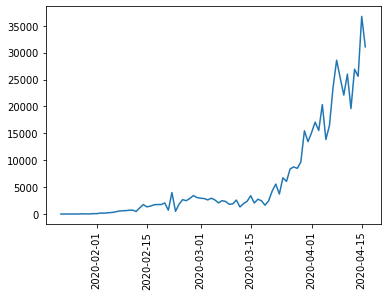

In [21]:
plt.plot(covid_by_date.loc[:, ['first_ord_differ']])
plt.xticks(rotation=90)

In [22]:
covid_by_date.tail(3)

,Confirmed,Deaths,Recovered,Logarithm,smoothing_win2,smoothing_win5,smoothing_win9,first_ord_differ
Date,,,,,,,,
2020-04-14,1976192.0,125984.0,474261.0,13.069513,461458.0,424568.8,375783.222222,25606.0
2020-04-15,2056055.0,134177.0,511019.0,13.144162,492640.0,451553.4,401839.222222,36758.0
2020-04-16,2152647.0,143801.0,542107.0,13.203219,526563.0,479552.8,428734.000000,31088.0


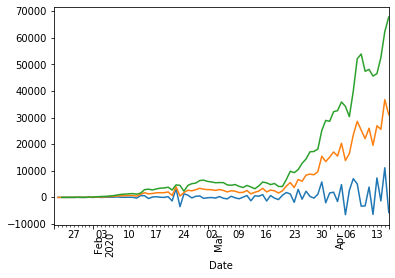

In [23]:
# compairing first order derivative with first-order differences
covid_by_date['first_ord_differ'].diff(1).plot()
covid_by_date['Recovered'].diff(1).plot()
covid_by_date['Recovered'].diff(2).plot()
plt.xticks(rotation=90)

plt.show()

In [24]:
covid_by_date['Deriv_1'] = 0
covid_by_date['Deriv_2'] = 0
covid_by_date.loc[1:, 'Deriv_1'] = covid_by_date['Recovered'].diff(1)
covid_by_date.loc[2:, 'Deriv_2'] = covid_by_date['Recovered'].diff(2)

**exponential_smoothing**

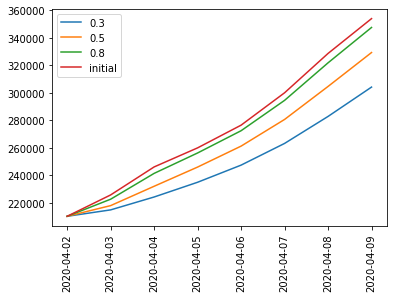

In [25]:
a = covid_by_date.loc[((covid_by_date.index > pd.to_datetime('2020-04-01')) 
                       & (covid_by_date.index < pd.to_datetime('2020-04-10'))), 'Recovered']
plt.plot(a.index, exponential_smoothing(covid_by_date.loc[(covid_by_date.index > pd.to_datetime('2020-04-01')) 
                                                          & (covid_by_date.index < pd.to_datetime('2020-04-10')), 'Recovered'],
                                        0.3), label='0.3')
plt.plot(a.index, exponential_smoothing(covid_by_date.loc[(covid_by_date.index > pd.to_datetime('2020-04-01')) 
                                                          & (covid_by_date.index < pd.to_datetime('2020-04-10')), 'Recovered'],
                                        0.5), label='0.5')
plt.plot(a.index, exponential_smoothing(covid_by_date.loc[(covid_by_date.index > pd.to_datetime('2020-04-01')) 
                                                          & (covid_by_date.index < pd.to_datetime('2020-04-10')), 'Recovered'],
                                        0.8), label='0.8')
plt.plot(a, label='initial')
plt.xticks(rotation=90)
plt.legend()

In [26]:
covid_by_date['exp_smoothing_05'] = exponential_smoothing(covid_by_date.loc[:, 'Recovered'],0.5)

In [29]:
covid_by_date['exponent_initial_difference'] =  covid_by_date['Recovered'].values - covid_by_date['exp_smoothing_05'].values

In [31]:
covid_by_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86 entries, 2020-01-22 to 2020-04-16
Data columns (total 12 columns):
Confirmed                      86 non-null float64
Deaths                         86 non-null float64
Recovered                      86 non-null float64
Logarithm                      86 non-null float64
smoothing_win2                 86 non-null float64
smoothing_win5                 86 non-null float64
smoothing_win9                 86 non-null float64
first_ord_differ               86 non-null float64
Deriv_1                        86 non-null float64
Deriv_2                        86 non-null float64
exp_smoothing_05               86 non-null float64
exponent_initial_difference    86 non-null float64
dtypes: float64(12)
memory usage: 11.2 KB


In [39]:
target = ['Recovered']
first_diff = covid_by_date.columns[[2,7]]
exponent = covid_by_date.columns[[2,10]]
logarithm = covid_by_date.columns[[2,3]]
all_features = covid_by_date.columns[2:]
my_features = covid_by_date.columns[[2, 3, 11]]

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [46]:
# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index <= split_date].copy(), data.loc[data.index >  split_date].copy()


In [100]:
train_c, test_c = split_data_b(covid_by_date, '2020-04-05')

*prediction horizon = 1*

In [101]:
X_train = train_c.iloc[:-1,:]
y_train = train_c[target].values[1:]
X_test = test_c.iloc[:-1,:]
y_test = test_c[target].values[1:]

In [102]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)


In [103]:
#first_diff
model_gb.fit(X_train.loc[:, first_diff], y_train.ravel()) 
X_pred_fd = model_gb.predict(X_test.loc[:, first_diff])

In [104]:
#exponent 
model_gb.fit(X_train.loc[:, exponent], y_train.ravel()) 
X_pred_exp = model_gb.predict(X_test.loc[:, exponent])

In [105]:
#logarithm
model_gb.fit(X_train.loc[:, logarithm], y_train.ravel()) 
X_pred_log = model_gb.predict(X_test.loc[:, logarithm])

In [106]:
#all_features 
model_gb.fit(X_train.loc[:, all_features], y_train.ravel()) 
X_pred_all = model_gb.predict(X_test.loc[:, all_features])

In [107]:
#my_features
model_gb.fit(X_train, y_train.ravel()) 
X_pred_mf = model_gb.predict(X_test)

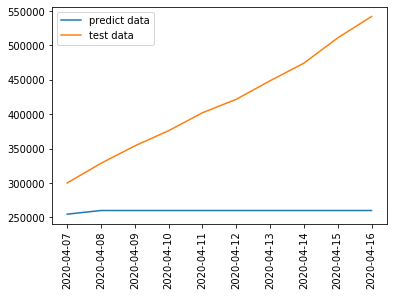

In [108]:
plt.plot(test_c.index[1:],X_pred_fd, label='predict data' )
plt.plot(test_c.index[1:],y_test, label='test data')
plt.xticks(rotation=90)
plt.legend()

**2. Оцените ошибку модели из п.1 .**

In [81]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [82]:
mean_absolute_percentage_error(y_test, X_pred_mf)

62.45245331789106

**3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.**

**4. Попробуйте предположить характер ряда** (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени